In [1]:
from funciones_LSTM import *
import holidays
from joblib import dump, load

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_parquet('../data_export/prueba_ml.parquet')
df.reset_index(inplace=True, drop=True)
df['dia_semana'] = df['fecha'].dt.weekday + 1
year = 2023
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df['rain'] = df['rain'].shift(1)
df['snowfall'] = df['snowfall'].shift(1)
df.fillna(0.0, inplace=True)
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]

9/9 [==============================] - 0s 15ms/step - loss: 0.0276
Valor final de Loss: 0.027566401287913322


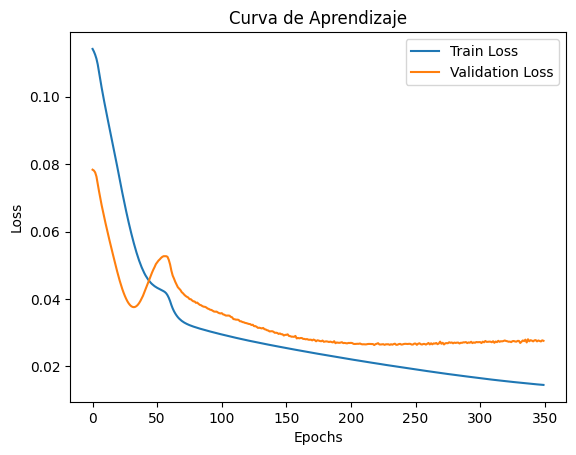

9/9 [==============================] - 2s 7ms/step


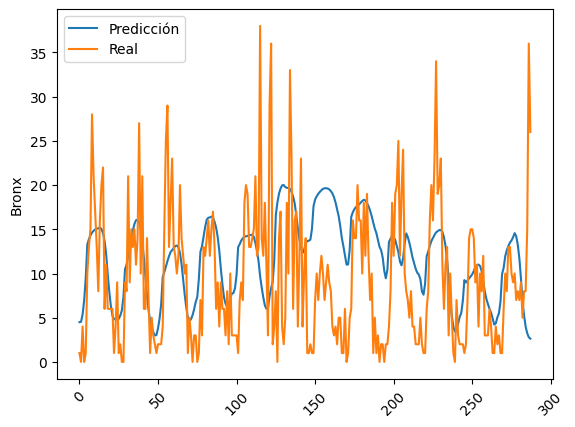

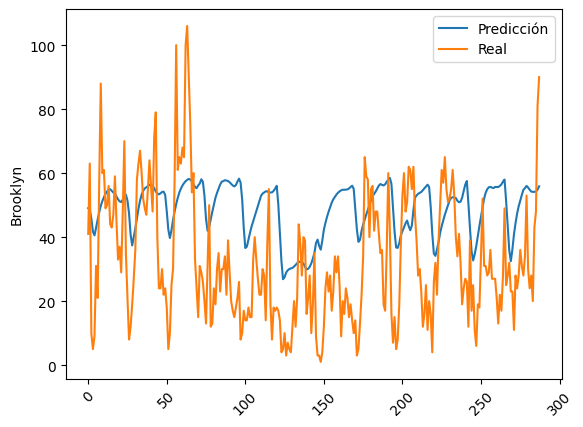

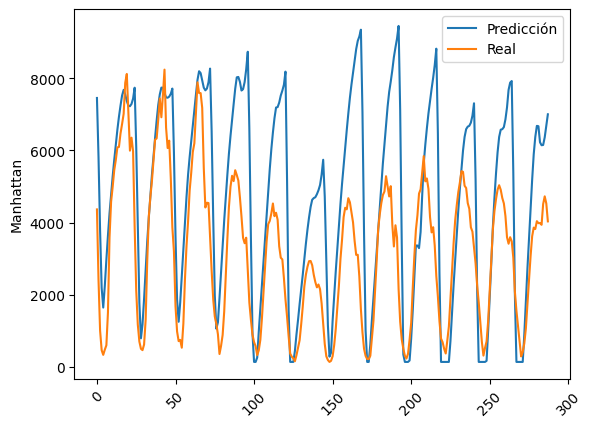

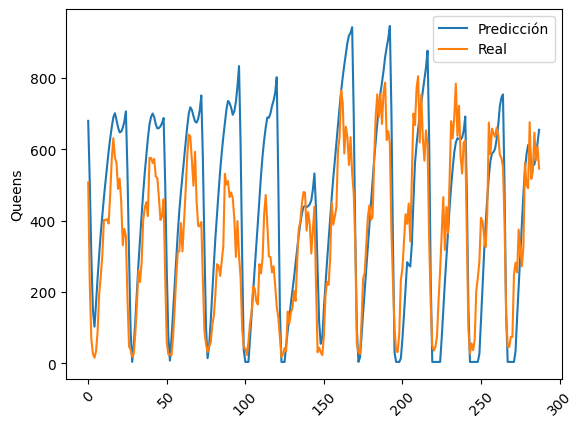

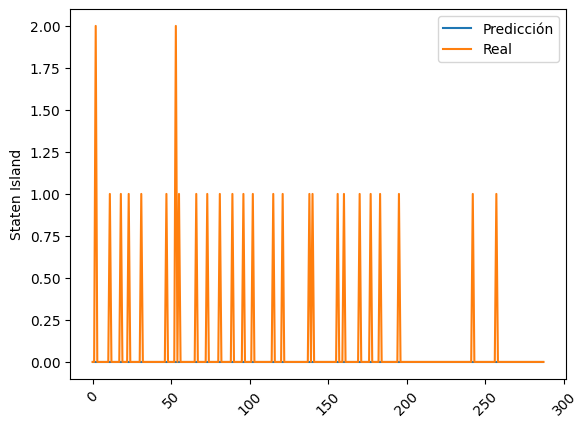

In [6]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss, rmse_dict = construir_modelo_cv(X, Y, nro_pasos=5, 
                    nro_capas_lstm=2, unidades_capa=[50,40], loss_='mse', act_salida='relu', act_lstm='relu', act_dense='sigmoid', learning_r=0.00001, 
                     epochs=350 )
graficar_curva_aprendizaje(history)
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y)

In [7]:
archivo = 'model_app_1.joblib'

dump(modelo, archivo)
dump(scaler_X, 'scaler_X.joblib')
dump(scaler_Y, 'scaler_Y.joblib')

INFO:tensorflow:Assets written to: C:\Users\alter\AppData\Local\Temp\tmpanjqt0fq\assets


INFO:tensorflow:Assets written to: C:\Users\alter\AppData\Local\Temp\tmpanjqt0fq\assets


['scaler_Y.joblib']

Probemos generar predicciones a partir de datos cargados por el usuario:

In [8]:
cantidad_dias = 7

In [9]:
import openmeteo_requests

import requests_cache
from retry_requests import retry
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 40.71427,
	"longitude": -74.00597,
	"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall"],
	"timezone": "America/New_York",
	"past_days": 1,
    "forecast_days": cantidad_dias
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall

df = pd.DataFrame(data = hourly_data)
df.head()


Coordinates 40.71033477783203°N -73.99307250976562°E
Elevation 51.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


,date,temperature_2m,relative_humidity_2m,rain,snowfall
0,2024-04-11 04:00:00+00:00,10.457500,85.0,0.0,0.0
1,2024-04-11 05:00:00+00:00,10.107500,86.0,0.0,0.0
2,2024-04-11 06:00:00+00:00,9.907499,87.0,0.0,0.0
3,2024-04-11 07:00:00+00:00,9.357500,86.0,0.0,0.0
4,2024-04-11 08:00:00+00:00,8.907499,97.0,0.0,0.0


In [10]:
df['fecha'] = df['date'].dt.date
df['año'] = df['date'].dt.year
df['mes'] = df['date'].dt.month
df['dia'] = df['date'].dt.day
df['hora'] = df['date'].dt.hour
df['dia_semana'] = df['date'].dt.weekday + 1
year = 2024
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df.head()

,date,temperature_2m,relative_humidity_2m,rain,snowfall,fecha,año,mes,dia,hora,dia_semana,holiday
0,2024-04-11 04:00:00+00:00,10.457500,85.0,0.0,0.0,2024-04-11,2024,4,11,4,4,0
1,2024-04-11 05:00:00+00:00,10.107500,86.0,0.0,0.0,2024-04-11,2024,4,11,5,4,0
2,2024-04-11 06:00:00+00:00,9.907499,87.0,0.0,0.0,2024-04-11,2024,4,11,6,4,0
3,2024-04-11 07:00:00+00:00,9.357500,86.0,0.0,0.0,2024-04-11,2024,4,11,7,4,0
4,2024-04-11 08:00:00+00:00,8.907499,97.0,0.0,0.0,2024-04-11,2024,4,11,8,4,0


In [11]:
from datetime import datetime

hora_actual = datetime.now().time()
fecha_actual = datetime.now().date()
hora = hora_actual.hour
dia = fecha_actual.day
mes = fecha_actual.month
anio = fecha_actual.year

In [12]:
indice = df.loc[(df['año'] == anio) & (df['mes'] == mes) & (df['dia'] == dia) & (df['hora'] == hora)].index[0]

In [13]:
df = df.loc[indice-4:,:]

In [14]:
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

In [16]:
modelo = load('model_app_1.joblib')
scaler_X = load('scaler_X.joblib')
scaler_Y = load('scaler_Y.joblib')
X_scaled = scaler_X.transform(X)

In [17]:
X_reshaped = generador_X(X_scaled, p=5)

5/5 [==============================] - 0s 4ms/step


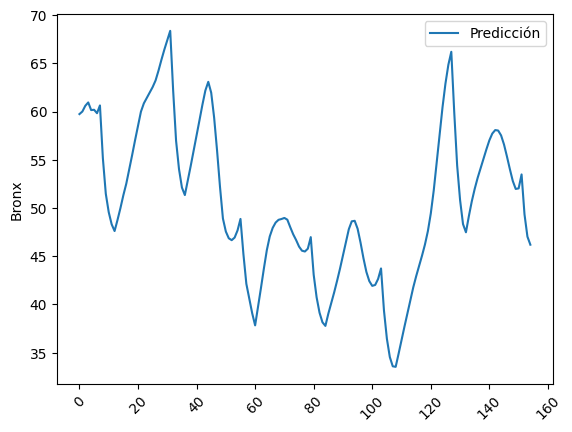

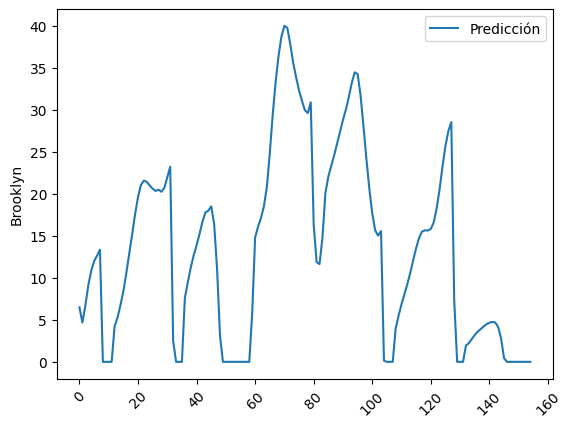

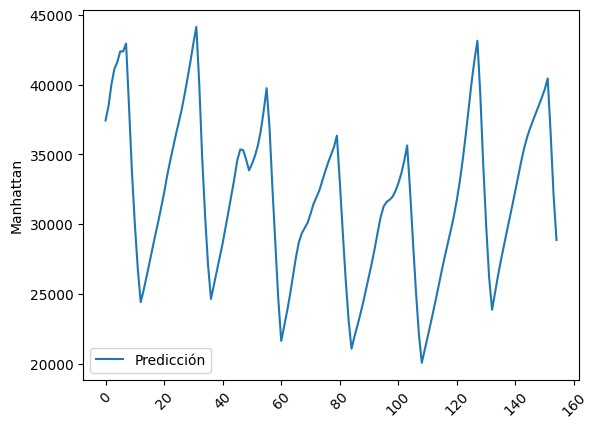

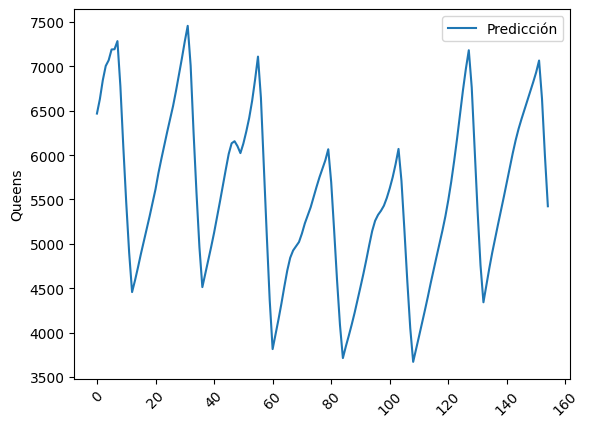

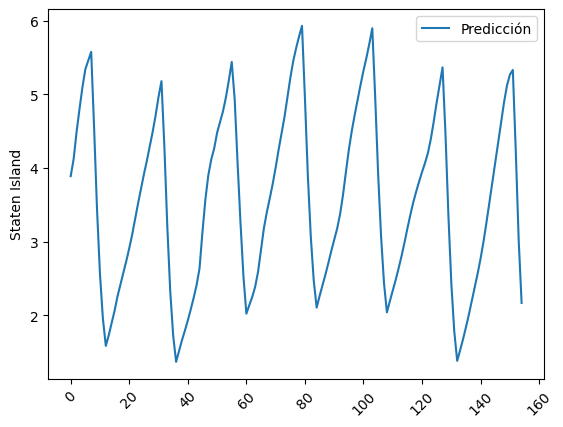

In [18]:
Y_predict = modelo.predict(X_reshaped)
Y_predict_df = pd.DataFrame(Y_predict, columns=columnas_Y)
Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
Y_predict_original_df = pd.DataFrame(Y_predict_original, columns=columnas_Y)
columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

for i in columnas_Y:
    sns.lineplot(x=Y_predict_original_df.index, y=Y_predict_original_df[i], label='Predicción')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

Aquí realizamos una prueba con la incorporación del cálculo de RMSE en escala original:



9/9 [==============================] - 0s 4ms/step
Valor final de Loss: 0.019970247521996498


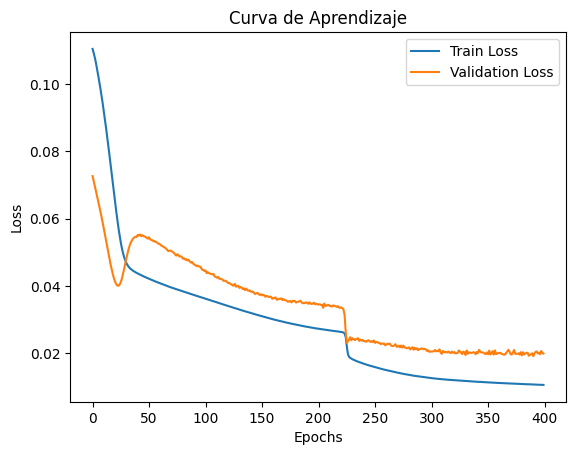

9/9 [==============================] - 0s 3ms/step


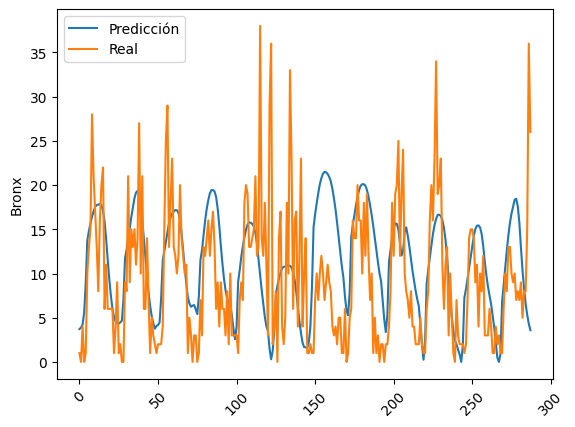

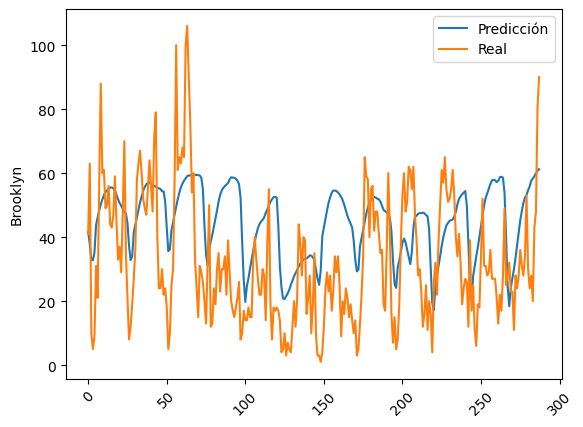

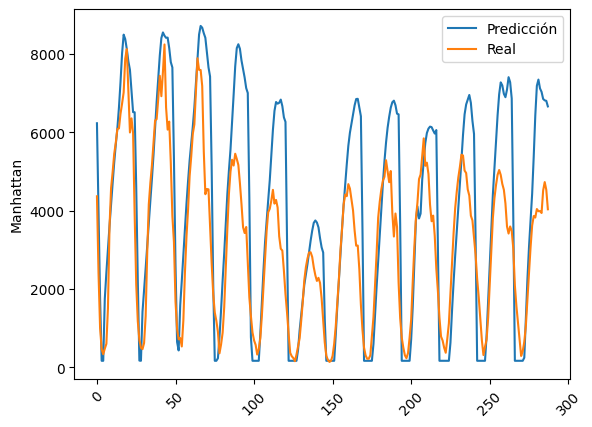

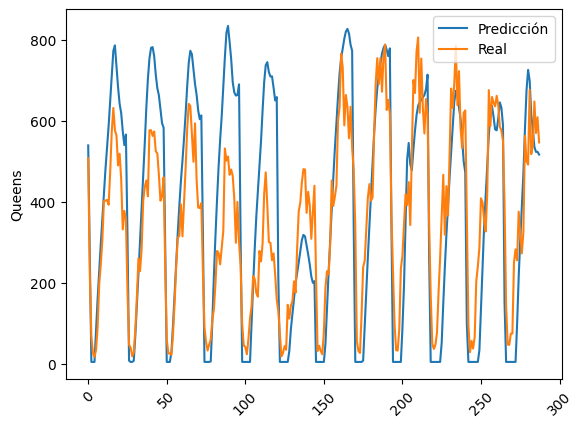

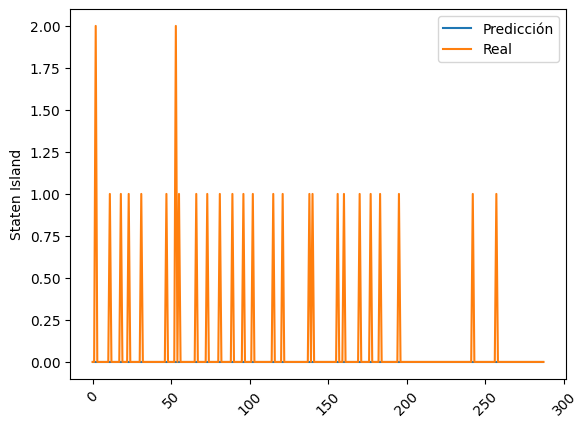

In [4]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss, rmse_dict = construir_modelo_cv(X, Y, nro_pasos=5, 
                    nro_capas_lstm=2, unidades_capa=[100,50], loss_='mse', act_salida='relu', act_lstm='relu', act_dense='sigmoid', learning_r=0.00001, 
                     epochs=400)
graficar_curva_aprendizaje(history)
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y)

In [5]:
rmse_dict

{'Bronx': 7.518096357708523,
 'Brooklyn': 21.99248705407037,
 'Manhattan': 1724.999286424747,
 'Queens': 158.52064997182057,
 'Staten Island': 0.3333333333333333}

Dejo una función de prueba aparte:

In [ ]:
def evaluar_modelos(X, Y, nro_pasos=25, nro_capas_lstm=[1], unidades_capa= [50], loss_= ['mse', 'mae'], act_salida=['linear'], act_lstm= ['relu'],
                    nro_capas_dense=0, unidades_dense=[0], act_dense= ['linear'], drop_out=0, scaler='minmax', csv_file= 'evaluacion.csv'):
    '''
    Evalúa múltiples configuraciones de modelos de red neuronal utilizando la técnica de validación cruzada y devuelve un DataFrame con los resultados.

    Argumentos:
    - X: Array numpy que contiene los datos de entrada.
    - Y: Array numpy que contiene los datos de salida.
    - nro_pasos: Número entero que indica la cantidad de pasos de tiempo a considerar para la secuencia de entrada. Por defecto, se establece en 25.
    - nro_capas_lstm: Lista de enteros que especifica la cantidad de capas LSTM que se deben probar en cada configuración del modelo. Por defecto, se establece en [1].
    - unidades_capa: Lista de enteros que especifica el número de unidades en cada capa LSTM a probar en cada configuración del modelo. Por defecto, se establece en [50].
    - loss_: Lista de cadenas que indica las funciones de pérdida a probar en cada configuración del modelo. Por defecto, se establece en ['mse', 'mae'].
    - act_salida: Lista de cadenas que especifica las funciones de activación a probar en la capa de salida del modelo en cada configuración. Por defecto, se establece en ['linear'].
    - act_lstm: Lista de cadenas que indica las funciones de activación a probar en las capas LSTM del modelo en cada configuración. Por defecto, se establece en ['relu'].
    - nro_capas_dense: Número entero que indica la cantidad máxima de capas densas a probar en cada configuración del modelo. Por defecto, se establece en 0.
    - unidades_dense: Lista de enteros que especifica el número de unidades en cada capa densa a probar en cada configuración del modelo. Por defecto, se establece en [0].
    - act_dense: Lista de cadenas que especifica las funciones de activación a probar en las capas densas del modelo en cada configuración. Por defecto, se establece en ['linear'].
    - drop_out: Valor flotante que representa la tasa de abandono para las capas Dropout, utilizadas para regularizar el modelo y prevenir el sobreajuste. Por defecto, se establece en 0.
    - scaler: Cadena que indica el método de escalado a aplicar a los datos. Puede ser 'minmax' para escalamiento Min-Max o 'standard' para escalamiento estándar. Por defecto, se establece en 'minmax'.
    - csv_file: Nombre del archivo donde se guardarán los datos de la evaluación. Por defecto 'evaluacion.csv'

    Devuelve:
    - evaluacion: DataFrame que contiene los resultados de la evaluación de los modelos, incluyendo métricas de rendimiento, tiempos de ejecución y configuraciones de los modelos probados.
    '''

    columnas = ['combinacion','nro_pasos', 'nro_capas_lstm', 'unidades_capa', 'nro_capas_dense', 'unidades_dense',  
                'loss_function', 'act_salida', 'act_lstm', 'act_dense', 'loss_value(mse)', 'cv_scores_mean', 'tiempo(s)']

    evaluacion = pd.DataFrame(columns=columnas)
    i = 0
    if nro_capas_dense > 0:
        combinaciones = nro_pasos*len(nro_capas_lstm)*len(loss_)*len(act_salida)*len(act_lstm)*(nro_capas_dense+1)*len(act_dense)
    if nro_capas_dense == 0:
        combinaciones = nro_pasos*len(nro_capas_lstm)*len(loss_)*len(act_salida)*len(act_lstm)*len(act_dense)
    mejor_score = float('inf')
    mejor_combinacion = 0
    
    for pasos in range(1,nro_pasos+1):
        for capas in nro_capas_lstm:
            for loss_f in loss_:
                for act_s in act_salida:
                    for act_l in act_lstm:
                        for capas_dense in range(nro_capas_dense+1):
                            for act_d in act_dense:
                                start_time = time.time()
                                modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss, rmse_dict = construir_modelo_cv(X, Y, 
                                                                                    pasos, capas, unidades_capa, loss_f, act_s, act_l,
                                                                                    drop_out=drop_out, nro_capas_dense=capas_dense, 
                                                                                    unidades_dense=unidades_dense, act_dense=act_d,
                                                                                    scaler=scaler)
                                end_time = time.time()
                                tiempo = end_time - start_time
                                unidades_capa_str = ', '.join(map(str, unidades_capa[0:capas]))
                                unidades_dense_str = ', '.join(map(str, unidades_dense[0:capas]))
                                scores_mean = np.mean(-scores)
                                evaluacion.loc[i] = [i+1, pasos, capas, unidades_capa_str, capas_dense, unidades_dense_str,
                                                    loss_f, act_s, act_l, act_d, loss, scores_mean, tiempo]
                                evaluacion.tail(1).to_csv(csv_file, index=False, mode='a', header=not i)
                                tiempo_promedio = np.mean(evaluacion['tiempo(s)'])
                                i+=1
                                if scores_mean < mejor_score:
                                    mejor_combinacion = i
                                    mejor_score = scores_mean
                                    best_model = modelo
                                    scaler_X_final = scaler_X
                                    scaler_Y_final = scaler_Y
                                    X_test_reshaped_final = X_test_reshaped
                                    Y_test_reshaped_final = Y_test_reshaped
                                    best_scores = scores
                                    history_final = history
                                    best_loss = loss
                                    best_rmse_dict = rmse_dict
                                print(f'Finalizada combinación {i} de {combinaciones}. Score= {np.round(scores_mean, 3)}')
                                print(f'Mejor combinación: {mejor_combinacion}. Score: {np.round(mejor_score, 3)}')
                                tiempo_restante = tiempo_promedio * (combinaciones - i) / 60
                                print(f'Quedan {round(tiempo_restante, 2)} minutos.')
    
    return evaluacion, best_model, scaler_X_final, scaler_Y_final, X_test_reshaped_final, Y_test_reshaped_final, best_scores, history_final, best_loss, best_rmse_dict